**Eksperimen dan Evaluasi**

Evaluasi performa model dilakukan dengan mengukur metrik utama klasifikasi: Accuracy,
Precision, Recall, dan F1-Score. Fokus utama evaluasi ini adalah untuk melihat efektivitas
model.

* Dataset: Online Retail dari UCI Machine Learning Repository [Klik sini untuk mengunduh dataset](https://archive.ics.uci.edu/dataset/352/online+retail)
* Topik: Customer Value Classification  
* Model: Logistic Regression & Random Forest



## A. Import Library


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from google.colab import data_table

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


## B. Load Dataset


In [ ]:

data_table.enable_dataframe_formatter()
df = pd.read_excel("Online Retail.xlsx")



## C. Preprocessing Data
- Menghapus data kosong. Pembersihan Data
Implementasi kode untuk membersihkan data, seperti menghapus nilai kosong (missing
values), memfilter transaksi yang dibatalkan, dan menghitung kolom Revenue.

- Menghapus transaksi cancel
- Membuat fitur customer


In [ ]:

# Drop missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove cancelled invoices
df = df[~df["InvoiceNo"].astype(str).str.startswith("C")]

# Create Revenue
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34



## D. Feature Engineering (Agregasi per Customer)
data retail memerlukan ekstraksi fitur untuk merangkum perilaku belanja. Dilakukan
perhitungan tiga metrik utama:
* Recency: Jumlah hari sejak transaksi terakhir (mengukur kebaruan).
* Frequency: Jumlah total invoice unik (mengukur loyalitas).
* TotalQuantity: Akumulasi jumlah barang yang dibeli (mengukur skala pembelian).
Ketiga fitur ini bertindak sebagai variabel independen yang akan dipelajari oleh model.


In [ ]:
last_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
customer_df = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (last_date - x.max()).days,
    "InvoiceNo": "nunique",
    "Revenue": "sum",
    "Quantity": "sum"
}).reset_index()

customer_df.columns = ["CustomerID", "Recency", "Frequency", "Monetary", "TotalQuantity"]

In [ ]:
print("Dataset Overview (Interactive):")
display(customer_df)

Dataset Overview (Interactive):


,CustomerID,Recency,Frequency,Monetary,TotalQuantity
0,12346.0,326,1,77183.60,74215
1,12347.0,2,7,4310.00,2458
2,12348.0,75,4,1797.24,2341
3,12349.0,19,1,1757.55,631
4,12350.0,310,1,334.40,197
...,...,...,...,...,...
4334,18280.0,278,1,180.60,45
4335,18281.0,181,1,80.82,54
4336,18282.0,8,2,178.05,103
4337,18283.0,4,16,2094.88,1397



## E. Labeling Customer Value
Variabel target (CustomerValue) dibentuk menggunakan metode Median Split pada
total pengeluaran pelanggan. Pelanggan dengan pengeluaran di atas median
dikategorikan sebagai High Value (1) dan di bawah median sebagai Low Value (0).
Metode ini menjamin keseimbangan kelas (balanced dataset) secara alami.


In [ ]:
# LABELING
median_monetary = customer_df["Monetary"].median()
customer_df["CustomerValue"] = (customer_df["Monetary"] >= median_monetary).astype(int)

In [ ]:
# SPLIT DATA
X = customer_df[["Recency", "Frequency", "TotalQuantity"]]
y = customer_df["CustomerValue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# MODEL 1: LOGISTIC REGRESSION
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)

In [ ]:
# MODEL 2: RANDOM FOREST
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


## F. Visualisasi Distribusi Kelas


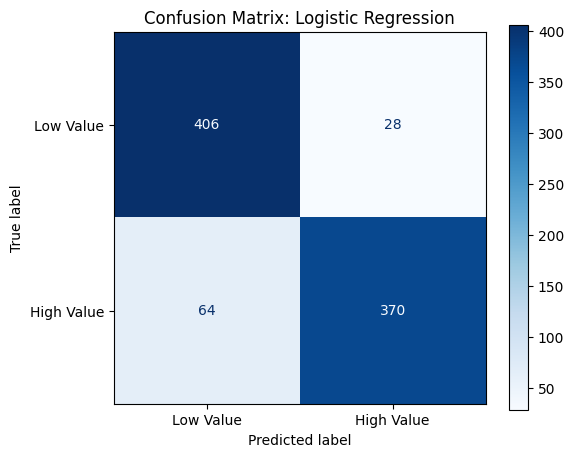

In [ ]:
# 1. Plot Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(6, 5))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Low Value", "High Value"])
disp_lr.plot(cmap="Blues", values_format="d", ax=ax)
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

* 406 (Kiri Atas): Model berhasil menebak 406 pelanggan Low Value dengan
benar.
* 370 (Kanan Bawah): Model berhasil menebak 370 pelanggan High Value
dengan benar.
* Kesalahan: Ada 28 pelanggan yang salah dikira High Value, dan 64
pelanggan yang salah dikira Low Value.

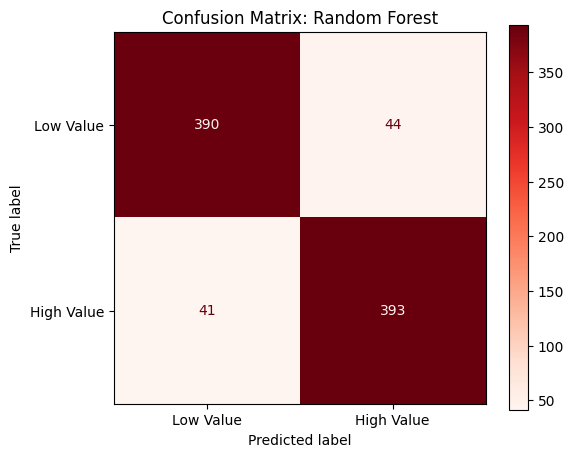

In [ ]:
# 2. Plot Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(6, 5))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Low Value", "High Value"])
disp_rf.plot(cmap="Reds", values_format="d", ax=ax)
plt.title("Confusion Matrix: Random Forest")
plt.show()

* 390 (Kiri Atas): Menebak 390 pelanggan Low Value dengan benar.
* 393 (Kanan Bawah): Menebak 393 pelanggan High Value dengan benar.
* Kesalahan: Ada 44 pelanggan yang salah dikira High Value, dan 41
pelanggan yang salah dikira Low Value.

Jika dibandingkan, Random Forest (Merah) memiliki keseimbangan yang lebih baik
dalam menebak pelanggan High Value (393 benar) dibandingkan Logistic Regression
(370 benar). Ini menunjukkan Random Forest lebih sensitif dalam menemukan
pelanggan yang menguntungkan bagi perusahaan


##Model 1 – Logistic Regression


In [ ]:

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.8940092165898618
[[406  28]
 [ 64 370]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       434
           1       0.93      0.85      0.89       434

    accuracy                           0.89       868
   macro avg       0.90      0.89      0.89       868
weighted avg       0.90      0.89      0.89       868




## I. Model 2 – Random Forest


In [ ]:

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.902073732718894
[[390  44]
 [ 41 393]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       434
           1       0.90      0.91      0.90       434

    accuracy                           0.90       868
   macro avg       0.90      0.90      0.90       868
weighted avg       0.90      0.90      0.90       868



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Fungsi untuk mengambil metrik
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return {'Model': model_name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1}

# Mengumpulkan hasil
performance = [
    get_metrics(y_test, y_pred_lr, 'Logistic Regression'),
    get_metrics(y_test, y_pred_rf, 'Random Forest')
]

# Menampilkan tabel performa
df_performance = pd.DataFrame(performance)
print("\n--- Tabel Perbandingan Performa ---")
display(df_performance)


--- Tabel Perbandingan Performa ---


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.894009,0.929648,0.852535,0.889423
1,Random Forest,0.902074,0.899314,0.905530,0.902411


**Hasil Accuracy, Precision, Recall, F1-score**

untuk Logistic Regresiion mendapatkan
* Akurasi 89.40%
* Precision 92.96%
* Recall 85.25%
* F1-Score 88.94%

Untuk Random Forest
* Akurasi 90.20%
* Precision 89.93%
* Recall 90.55%
* F1-Score 90.24%

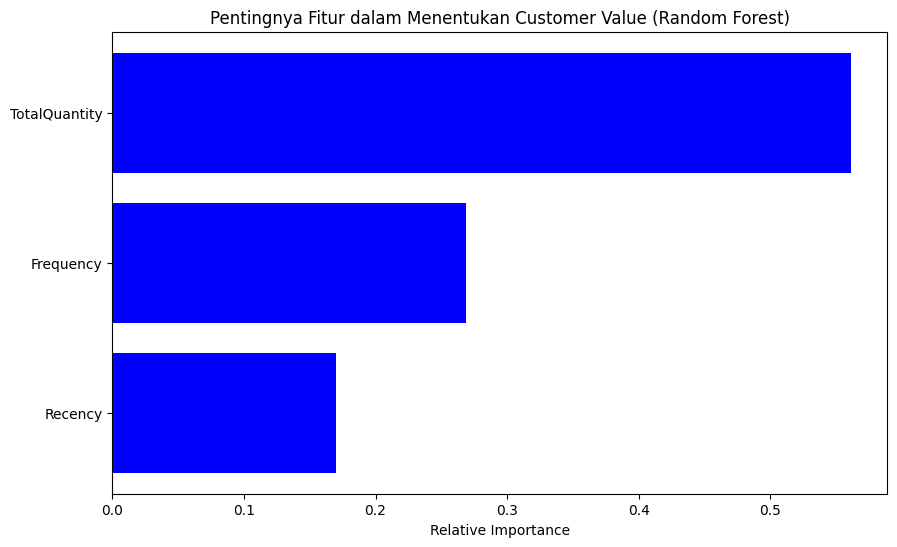

In [ ]:
# Menghitung tingkat kepentingan fitur
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)

# Membuat Grafik
plt.figure(figsize=(10, 6))
plt.title('Pentingnya Fitur dalam Menentukan Customer Value (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **KESIMPULAN**

Penelitian ini membandingkan Logistic Regression dan Random Forest untuk mengklasifikasikan customer value berdasarkan perilaku transaksi.
Hasil menunjukkan bahwa Random Forest memiliki performa yang lebih baik serta mampu mengidentifikasi fitur yang paling berpengaruh dalam menentukan nilai pelanggan.


